# KV Project 3: Iowa liquor sales 2015-2016

#### Deliverable: Total liquor sales for 2015 and 2016 (projected) by county and for entire state (in dollars)

#### Problem statement: Generate a model (and report model accuracy) to predict total liquor sales by county in 2016, based on data from 2015. The model must predict new data with >90% accuracy

#### Primary Stakeholders: Iowa state legislature (+tax committee), Iowa state tax board

#### Motivation: State legislature is considering changes in the liquor tax rates (to augment revenues, to motivate better health outcomes, or for other reasons)

### Methodology
1. Acquire the data
2. Data exploration and cleaning
3. Data mining (and additional cleaning as needed)
4. Data visualization and correlations
5. Build model
6. Report on deliverables

### (0) Import libraries

In [1]:
% matplotlib inline

from collections import defaultdict
import datetime
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 5, 5
import numpy as np
import pandas as pd
from sklearn import linear_model, preprocessing, metrics
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict

### (1, 2) Data acquisition, exploration and cleaning

The dataset contains individual transactions from each store with a class E liquor license in the state of Iowa, for each category of liquor item sold. A reduced dataset was acquired from the Iowa government website (as a .csv file), and only contains 10% of the full data in order to minimize potential computation issues. This reduced dataset contains ~270K transactions from 1161 stores across al of Iowa's 99 counties, including date of transaction, item description, quantity sold (in volume and number), cost and price per bottle, and sale in dollars. 

Here are a couple of aspects of the dataset that needed cleaning:
1. All monetary quantities were converted to float to enable calculations
2. Dates were converted to datetime format
3. NA values were removed

### (3) Data mining
1. The data was first filtered to remove stores that opened after Mar 1, 2015, and closed before Oct 1, 2015. The data from these stores may not be a good predictor of total 2015 sales compared to stores that were open for longer, and may skew the model (resulting in poor predictions) if included. 
2. Additional data, such as total 2015 sales, 2015 Q1 sales, 2016 Q1 sales and average margin per transaction FOR EACH STORE were created

In [ ]:
# Code snippet for filtering stores by first and last transaction dates in dataset

# Determine which stores were open all of 2015
# Find the first and last sales date.
dates = df.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]

# Filter out stores that opened or closed throughout the year
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
df = df[df["Store Number"].isin(good_stores)]

### (3) Additional cleaning
After filtering the data and creating additional data columns, some additional cleaning was necessary to remove NaNs resulting from the additional columns, as well as introduce some additional data transformations. The final cleaned table had 1143 rows (1 for each unique store), located in the 99 counties of Iowa 

In [3]:
sales = pd.read_csv("sales_cleaned2.csv")

# Convert dates
sales["First Date"] = pd.to_datetime(sales["First Date"], format = "%Y-%m-%d")
sales["Last Date"] = pd.to_datetime(sales["Last Date"], format = "%Y-%m-%d")

# Check which columns have NaN, and deal with them
sales.columns[pd.isnull(sales).any()].tolist()

# Drop NaN
sales_clean = sales.dropna()

,Unnamed: 0,store_number,zipcode,County,2015_margin_avg_$,2015_price_avg_$pL,2015_volume_total_L,2015_volume_avg_L,2015_sales_total_$,2015_sales_avg_$,city,County number,2015Q1_sales_total_$,2015Q1_volume_total_L,2016Q1_sales_total_$,2016Q1_volume_total_L,First Date,Last Date
0,0,2106,50613,Black Hawk,92.665779,17.844997,9719.85,18.478802,146038.70,277.640114,CEDAR FALLS,7,39287.29,2526.10,30478.75,2116.25,2015-01-08,2016-03-31
1,1,2113,50543,Webster,21.149932,18.507700,659.85,4.488776,9310.22,63.334830,GOWRIE,94,2833.25,177.11,2065.90,177.00,2015-01-07,2016-03-23
2,2,2130,50703,Black Hawk,95.215652,16.817589,6879.37,17.594297,111583.91,285.380844,WATERLOO,7,24272.57,1447.25,27856.11,1556.90,2015-01-08,2016-03-31
3,3,2152,50469,Cerro Gordo,18.351277,13.020765,633.37,4.491986,7721.08,54.759433,ROCKWELL,17,2003.46,151.74,904.66,87.50,2015-01-08,2016-02-25
4,4,2178,52172,Allamakee,34.454430,16.053844,1917.12,8.089114,24324.18,102.633671,WAUKON,3,5856.41,409.81,5588.50,520.80,2015-01-07,2016-03-30


### (4) Data visualization and correlations

In [37]:
# Compute correlations
sales_clean.corr()

,Unnamed: 0,store_number,2015_margin_avg_$,2015_price_avg_$pL,2015_volume_total_L,2015_volume_avg_L,2015_sales_total_$,2015_sales_avg_$,County number,2015Q1_sales_total_$,2015Q1_volume_total_L,2016Q1_sales_total_$,2016Q1_volume_total_L
Unnamed: 0,1.000000,0.936957,-0.086396,0.058226,-0.359733,-0.111916,-0.323195,-0.086127,-0.008113,-0.311475,-0.350045,-0.298326,-0.323211
store_number,0.936957,1.000000,-0.062352,0.004937,-0.412657,-0.074192,-0.376246,-0.062249,-0.008096,-0.360313,-0.397547,-0.354313,-0.379706
2015_margin_avg_$,-0.086396,-0.062352,1.000000,0.120684,0.443491,0.936768,0.446288,0.999975,0.007377,0.419517,0.410516,0.021345,0.017566
2015_price_avg_$pL,0.058226,0.004937,0.120684,1.000000,0.130079,-0.083952,0.170287,0.122172,0.100787,0.166982,0.122724,-0.017654,-0.023711
2015_volume_total_L,-0.359733,-0.412657,0.443491,0.130079,1.000000,0.439668,0.992454,0.443910,0.036811,0.975140,0.973996,0.166283,0.174481
2015_volume_avg_L,-0.111916,-0.074192,0.936768,-0.083952,0.439668,1.000000,0.416107,0.935613,-0.014389,0.393769,0.410962,0.026788,0.025583
2015_sales_total_$,-0.323195,-0.376246,0.446288,0.170287,0.992454,0.416107,1.000000,0.446959,0.044827,0.983786,0.968235,0.149051,0.154919
2015_sales_avg_$,-0.086127,-0.062249,0.999975,0.122172,0.443910,0.935613,0.446959,1.000000,0.007742,0.420029,0.410765,0.021464,0.017654
County number,-0.008113,-0.008096,0.007377,0.100787,0.036811,-0.014389,0.044827,0.007742,1.000000,0.048668,0.040181,0.001704,0.002605
2015Q1_sales_total_$,-0.311475,-0.360313,0.419517,0.166982,0.975140,0.393769,0.983786,0.420029,0.048668,1.000000,0.986746,0.152734,0.156752


#### Observations
1. Avg sale or margin per transaction, avg price per L per transaction, avg volume per transaction all have low correlation with 2015 total sales
2. 2015 Q1 sales and volume are highly correlated with 2015 total sales (r > 0.98)

#### Histogram of Total 2015 sales - Some outliers, but we first want to check how model performs without removing outliers 
<img src="Totalsaleshist.png" width=400 height=250>

#### Total 2015 sales vs Total 2015 Q1 sales (all in dollars)
<img src="TotalsalesbyQ1.png" width=400 height=250>

#### Total 2015 sales (in dollars) vs Total 2015 Q1 volume sold (in liters)
<img src="TotalsalesbyQ1vol.png" width=400 height=250>

#### Total 2015 sales vs Average margin per transaction (all in dollars)
<img src="Totalsalesbymargin.png" width=400 height=250>

### (5) Model building
### Model1: Linear Regresison with cross validation, with only 2015 Q1 sales as predictor

#### 1.1: Data preprocessing

In [38]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(sales_clean["2015Q1_sales_total_$"], 
                                                    sales_clean["2015_sales_total_$"],
                                                    test_size = 0.3)

In [39]:
# Training set variables standardize
Xs_train = preprocessing.scale(X_train)
ys_train = y_train
Xs_train = Xs_train.reshape(-1,1)
print(Xs_train.shape)

(800, 1)


#### 1.2: Model building

In [40]:
lm1 = linear_model.LinearRegression()
model = lm1.fit(Xs_train, ys_train)
pred_model = lm1.predict(Xs_train)

#### 1.3: Model metrics

In [41]:
# Cross-validation
scores = cross_val_score(lm1, Xs_train, ys_train, cv = 6)
predcv = cross_val_predict(lm1, Xs_train, ys_train, cv = 6)
print(scores)

R2_model = metrics.r2_score(ys_train, pred_model)
R2_cv_scores = np.mean(scores)
rmse_model = (metrics.mean_squared_error(ys_train, pred_model))**0.5
rmse_cv = (metrics.mean_squared_error(ys_train, predcv))**0.5

print("R2_model_train: {}, R2_cv: {}".format(R2_model, R2_cv_scores))
print("rmse_model_train: {}, rmse_cv: {}".format(rmse_model, rmse_cv))

[ 0.92502374  0.9740132   0.85043665  0.96179457  0.92945303  0.97281101]
R2_model_train: 0.9621057366839447, R2_cv: 0.9355886993666567
rmse_model_train: 9429.301841235469, rmse_cv: 9635.37570585619


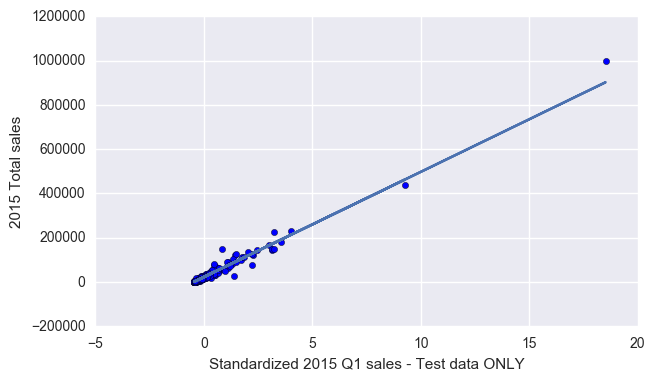

R2_test: 0.9735533830536662, RMSE_test: 10889.13208879274


In [42]:
# Predictions and scores on test set
Xs_test = (X_test - np.mean(X_train))/np.std(X_train)
ys_test = y_test
Xs_test = Xs_test.reshape(-1,1)

pred1 = lm1.predict(Xs_test)
pred1 = pred1.reshape(-1,1)

plt.figure(figsize=(7,4))
plt.xlabel("Standardized 2015 Q1 sales - Test data ONLY")
plt.ylabel("2015 Total sales")
plt.scatter(Xs_test, ys_test, label="Actual (test data ONLY)")
plt.plot(Xs_test, pred1, label="Predicted")
plt.show()

R2_test = metrics.r2_score(ys_test, pred1)
rmse_test = (metrics.mean_squared_error(ys_test, pred1))**0.5

print("R2_test: {}, RMSE_test: {}".format(R2_test, rmse_test))

##### Model of total yearly sales with Q1 sales as only predictor seems do well on new datasets (R2 > 90% goal), even with outliers

#### 1.4: Model coefficients and intercepts

In [43]:
print("Intercept: {}, Coeff: {}".format(lm1.intercept_, lm1.coef_))

Intercept: 22517.34522500001, Coeff: [ 47512.0977706]


### (6) Predictions and deliverables

In [44]:
# Standardize "2016 Q1 sales" values
Xs_2016 = preprocessing.scale(sales_clean["2016Q1_sales_total_$"])
Xs_2016 = Xs_2016.reshape(-1,1)
# Predict using lm1
Y1_2016 = lm1.predict(Xs_2016)

sales_clean["2016_proj_sales_total_$"] = Y1_2016
total_sales_by_county = pd.pivot_table(sales_clean, index="County", 
                                       values=["2015_sales_total_$", "2016_proj_sales_total_$"], 
                                      aggfunc=np.sum)
total_sales_by_county.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,2015_sales_total_$,2016_proj_sales_total_$
County,,
Adair,42353.24,65966.155803
Adams,10245.14,12394.392216
Allamakee,79918.47,72023.067814
Appanoose,77033.64,181670.904676
Audubon,2869.68,6227.612786


In [45]:
# 2015 and 2016 (projected) sales
total_sales_by_county.sum()

2015_sales_total_$         2.703663e+07
2016_proj_sales_total_$    2.573733e+07
dtype: float64

In [50]:
# Counties with biggest change
total_sales_by_county["% change from 2015"] = (((total_sales_by_county["2016_proj_sales_total_$"] - total_sales_by_county["2015_sales_total_$"])
                                                *100/total_sales_by_county["2015_sales_total_$"]))
total_sales_by_county.sort_values("% change from 2015", ascending=False, inplace=True)

### Conclusions
##### 1. Overall sales are projected to go DOWN by 4.8%
##### 2. Wayne county is projected to have the biggest increase (+558%)
##### 3. Delaware county is projected to have the largest decrease (-64%)

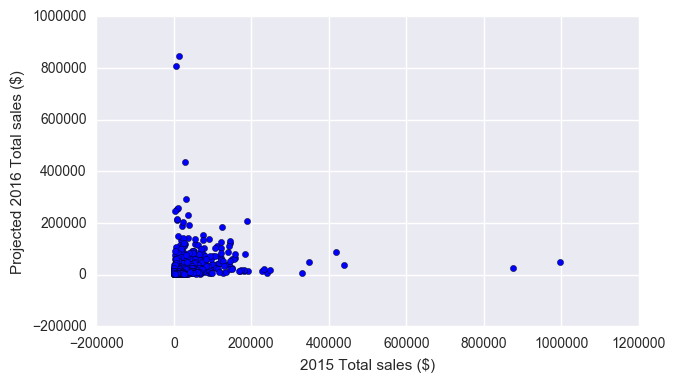

In [55]:
# Plot 2015vs 2016 sales for each store
plt.figure(figsize=(7,4))
plt.scatter(sales_clean["2015_sales_total_$"], sales_clean["2016_proj_sales_total_$"])
plt.xlabel("2015 Total sales ($)")
plt.ylabel("Projected 2016 Total sales ($)")
plt.show()

### Appendix

### Model 2: LR with CV, with 2015 Q1 sales and 2015 Q1 volume as predictors

In [57]:
X = sales_clean[["2015Q1_sales_total_$", "2015Q1_volume_total_L"]]
Y = sales_clean[["2015_sales_total_$"]]
X.head()

,2015Q1_sales_total_$,2015Q1_volume_total_L
0,39287.29,2526.10
1,2833.25,177.11
2,24272.57,1447.25
3,2003.46,151.74
4,5856.41,409.81


#### 2.1: Data preprocessing

In [58]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

# Training set variables standardize
Xs_train = preprocessing.scale(X_train)
ys_train = y_train

#### 2.2: Model building

In [59]:
lm2 = linear_model.LinearRegression()
model2 = lm2.fit(Xs_train, ys_train)
pred_model2 = lm2.predict(Xs_train)

#### 2.3: Model metrics

In [60]:
# Cross-validation
scores2 = cross_val_score(lm2, Xs_train, ys_train, cv = 6)
predcv2 = cross_val_predict(lm2, Xs_train, ys_train, cv = 6)

R2_model2 = metrics.r2_score(ys_train, pred_model2)
R2_cv_scores2 = np.mean(scores2)
rmse_model2 = (metrics.mean_squared_error(ys_train, pred_model2))**0.5
rmse_cv2 = (metrics.mean_squared_error(ys_train, predcv2))**0.5

print("R2_model_train: {}, R2_cv: {}".format(R2_model2, R2_cv_scores2))
print("rmse_model_train: {}, rmse_cv: {}".format(rmse_model2, rmse_cv2))

R2_model_train: 0.958668215010634, R2_cv: 0.9278143718863938
rmse_model_train: 9646.520077944488, rmse_cv: 10013.602512584557


#### 2.4: Model coefficients

In [61]:
print("Intercept: {}, Coeff: {}".format(lm2.intercept_, lm2.coef_))

Intercept: [ 22186.248875], Coeff: [[ 54373.31222683  -8097.57622882]]


#### 2.5: Predictions on test set

In [62]:
# Predictions and scores on test set
Xs_test = (X_test - np.mean(X_train))/np.std(X_train)
ys_test = y_test

pred2 = lm2.predict(Xs_test)

R2_test = metrics.r2_score(ys_test, pred2)
rmse_test = (metrics.mean_squared_error(ys_test, pred2))**0.5

print("R2_test: {}, RMSE_test: {}".format(R2_test, rmse_test))

R2_test: 0.9779404621806511, RMSE_test: 10180.27300284995
